In [1]:
import preprocessing.preprocessing as pp
import torch
from models import nodeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from visualization import mesh_viewer
import evaluation.evaluation as ev
import graph_matching.graph_matching as gm
import graph_matching.graph_connection as gc
import training.training as tt

import tifffile as tiff
import networkx as nx
from torch_geometric.utils.convert import from_networkx

# Create the graph from the combined masks and assign labels to it

In [2]:
# creating the graph
nodesFileComb =  "~/Documents/Intestine/combined-mask/nodes_bs2_fh.csv"
edgesFileComb = "~/Documents/Intestine/combined-mask/edges_bs2_fh.csv"

nodes_c = pd.read_csv(nodesFileComb, sep = ";", index_col= "id")
edges_c = pd.read_csv(edgesFileComb, sep = ";", index_col= "id")

# scaling with the factors provided by luciano
nodes_c = pp.scalePosition(nodes_c, (1.65,1.65,6))

# creating the graph
G_comb = pp.createGraph(nodes_c, edges_c)
G_comb_einf = pp.convertToEinfach(G_comb, self_loops = False, isolates = False)

### Assign the labels based on the masks

In [3]:
# base the classifcation on the mask labels at the position of the nodes
nerve_mask =  "../Intestine/nerve-mask/nerve_mask_stack_255_fh.tif"
lymph_mask =  "../Intestine/lymph-mask/lymph_mask_stack_255_fh.tif"

# read tif and convert to numpy 
nerve_mask_np = np.array(tiff.imread(nerve_mask)).T
lymph_mask_np = np.array(tiff.imread(lymph_mask)).T

# extracting the labels for the graph
mask_labels_num = gm.assignNodeLabelsByMask([nerve_mask_np, lymph_mask_np], G = G_comb_einf, voxel_size= (0.00217391,0.00217391,0.00217391), scaling_vector= (1.65, 1.65, 6), kernel_size=9)

# create dictionary to convert int labels to char labels
char_class_reverse = {}
char_class_reverse[0] = "n"
char_class_reverse[1] = "l"

# create a copy that will be used for relabeling
mask_labels = mask_labels_num.copy()

# adjust the node names
for key in mask_labels:
    mask_labels[key] = str(key) + char_class_reverse[mask_labels[key]]

# relabel the graph with the mask based labeling
G_comb_einf_lab = nx.relabel_nodes(G_comb_einf, mask_labels)

# check if all the masks have a label (otherwise class -1 exists)
np.unique(list(mask_labels_num.values()), return_counts = True)


(array([0, 1]), array([1308, 2407]))

### Visualize the graph

Dual graph from combined extraction with mask based labeling.


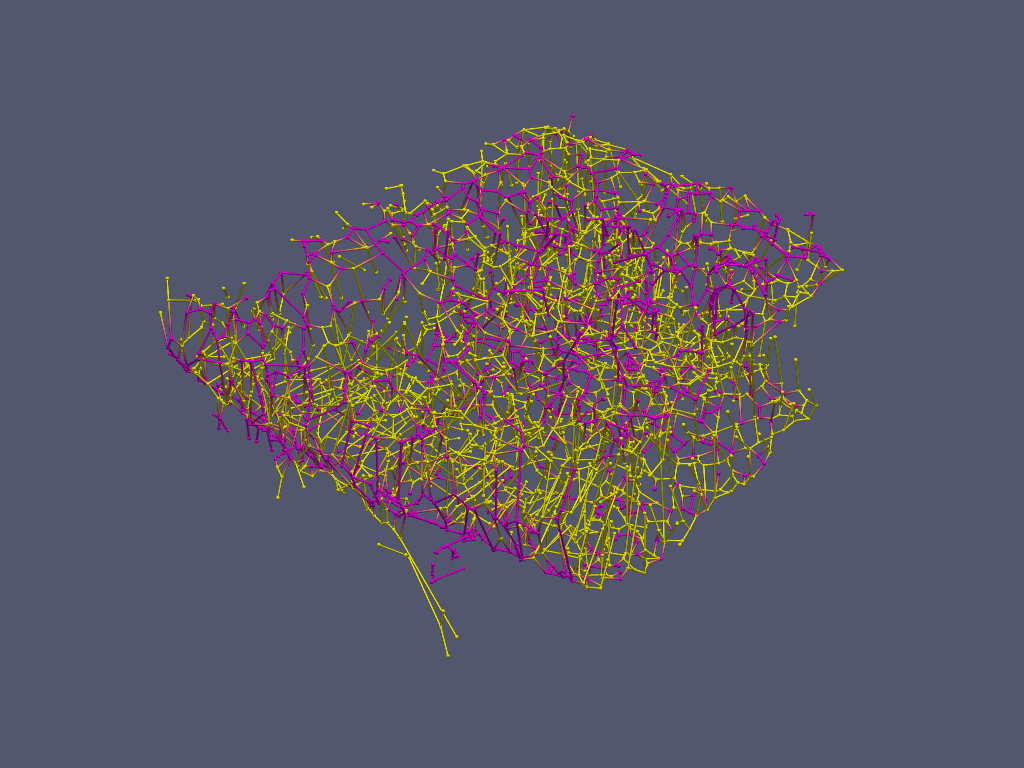

In [4]:
print("Dual graph from combined extraction with mask based labeling.")
mesh_viewer.renderNXGraph(G_comb_einf_lab, dual = False, vtk = 0, backend = "static")

### Create and visualize the dual graph

Dual graph from combined extraction with mask based labeling.


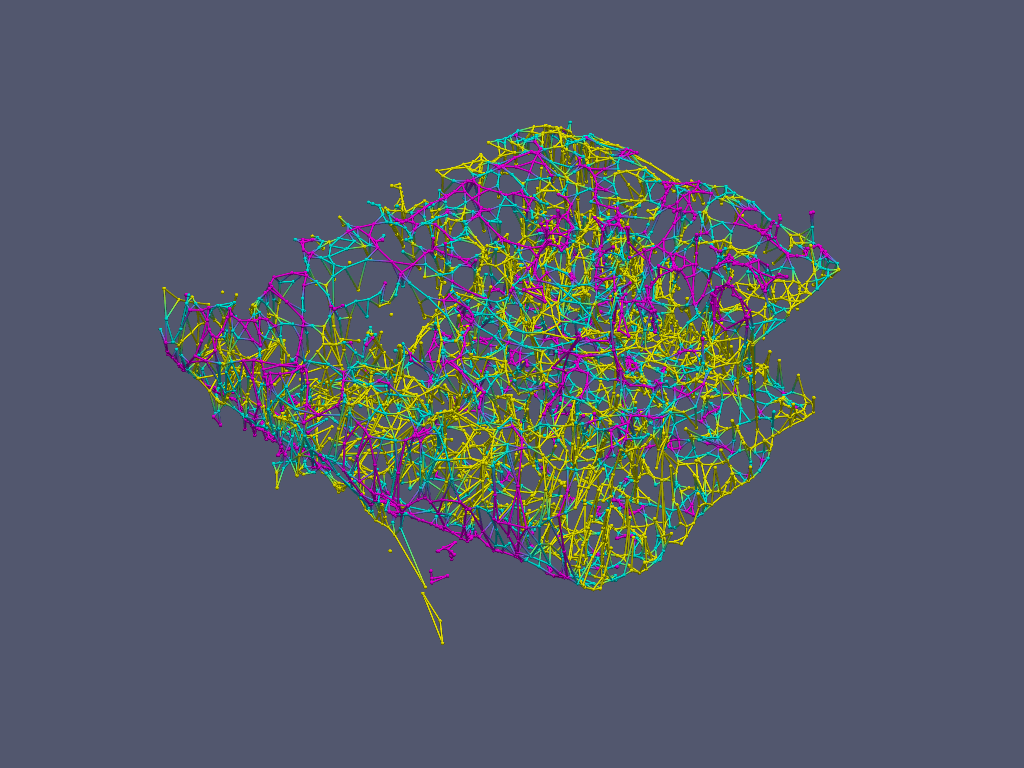

In [5]:
L_comb_einf_lab = pp.makeDual(G_comb_einf_lab)
print("Dual graph from combined extraction with mask based labeling.")
mesh_viewer.renderNXGraph(L_comb_einf_lab, dual = True, vtk = 0, backend = "static")

# Start playing with models for node classification

In [6]:
# loading potential architectures
netGCN = nodeClassifier.GCN_VS
netSAGE = nodeClassifier.SAGE_VS

### Classification on G

In [7]:
# enrich nodes with information form edges
pp.enrichNodeAttributes(G_comb_einf_lab)
GX_comb_einf_lab = from_networkx(G_comb_einf_lab)
GX_comb_einf_lab.y = torch.tensor(list(mask_labels_num.values()))


# extract the classes and features for model input
num_feat_comb = GX_comb_einf_lab.x.shape[1]
num_class_comb = len(np.unique(GX_comb_einf_lab.y))


# create a network arch
SAGE1 = nodeClassifier.nodeClassifier(netSAGE, 64, features = np.arange(num_feat_comb), classes = num_class_comb, num_layers= 4,  lr = 0.00134, weight_decay= 0.0002) 

# create a trainer for the model
SAGE1_TR = tt.Trainer(SAGE1,GX_comb_einf_lab)


100%|██████████| 600/600 [00:58<00:00, 10.26it/s]


Total number of epochs: 600


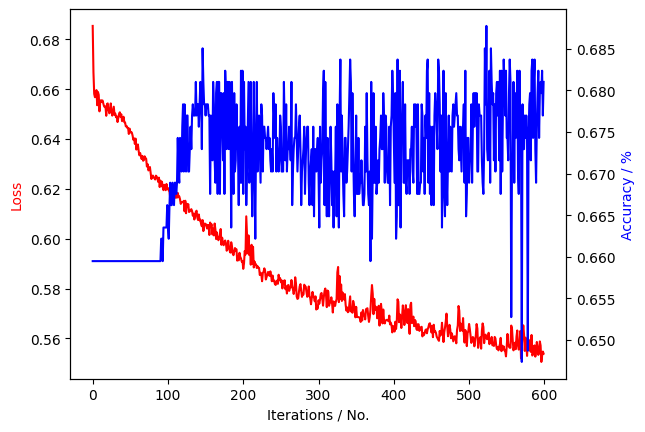

In [8]:
# train the model for a given number of epochs
loss_l, acc_l = SAGE1_TR.trainXepochs(1000)

# total number of training epoch for this model
print("Total number of epochs: " + str(SAGE1_TR.totalEpoch))

# plot the loss and val acc over the epochs
ev.plot_loss_acc(loss_l, acc_l)

100%|██████████| 1000/1000 [01:26<00:00, 11.54it/s]


Total number of epochs: 1600


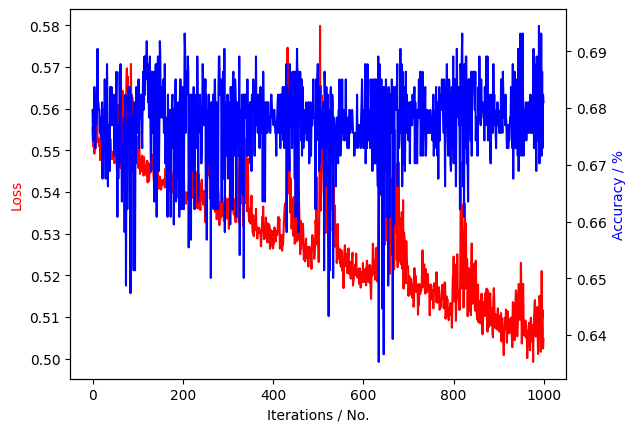

In [13]:
# throw in another 1000 epochs

# train the model for a given number of epochs
loss_l, acc_l = SAGE1_TR.trainXepochs(1000)

# total number of training epoch for this model
print("Total number of epochs: " + str(SAGE1_TR.totalEpoch))

# plot the loss and val acc over the epochs
ev.plot_loss_acc(loss_l, acc_l)

Whole set Accuracy: 0.7200538358008075


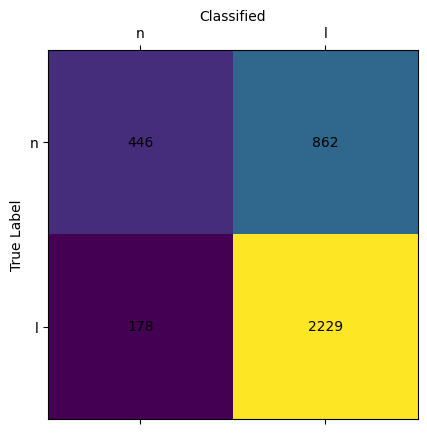

In [16]:
full_mask_comb = torch.tensor(np.arange(0, GX_comb_einf_lab.y.shape[0]))
pred_whole_comb = SAGE1_TR.model.predictions(GX_comb_einf_lab)
pred_whole_comb_acc = SAGE1_TR.model.test(GX_comb_einf_lab, full_mask_comb)


print("Whole set Accuracy: " + str(pred_whole_comb_acc))
ev.plot_confusion_matrix(np.array(SAGE1_TR.nxGraph.y), pred_whole_comb, char_class_reverse.values())


# somehow this bugs
#rocL_comb = ev.eval_roc_auc(GX_comb_einf_lab.y, SAGE1_TR.model.predictions(GX_comb_einf_lab, max_prob = False))
#print("ROC AUC: " + str(rocL_comb))


### Classification on L

In [32]:
LX_comb_einf_lab = from_networkx(L_comb_einf_lab)
class_label_list, node_lab, node_lab_explain =  pp.getLablesForDual(L_comb_einf_lab)


LX_comb_einf_lab.y = torch.tensor(class_label_list)


# extract the classes and features for model input
num_feat_dual_comb = LX_comb_einf_lab.x.shape[1]
num_class_dual_comb = len(np.unique(LX_comb_einf_lab.y))


# create a network arch
SAGE1L = nodeClassifier.nodeClassifier(netSAGE, 32, features = np.arange(num_feat_dual_comb), classes = num_class_dual_comb, num_layers= 3,  lr = 0.00334, weight_decay= 0.0002) 

# create a trainer for the model
SAGE1L_TR = tt.Trainer(SAGE1L,LX_comb_einf_lab)


100%|██████████| 2000/2000 [03:22<00:00,  9.89it/s]


Total number of epochs: 2000


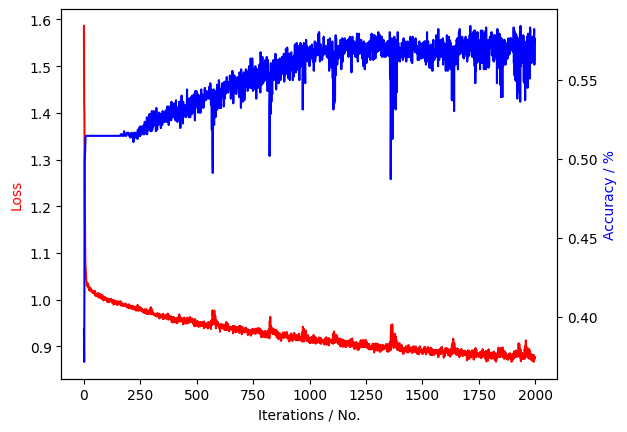

In [33]:
# train the model for a given number of epochs
loss_l, acc_l = SAGE1L_TR.trainXepochs(2000)

# total number of training epoch for this model
print("Total number of epochs: " + str(SAGE1L_TR.totalEpoch))

# plot the loss and val acc over the epochs
ev.plot_loss_acc(loss_l, acc_l)

Whole set Accuracy: 0.5913725490196079
ROC AUC: 0.7575523033646543


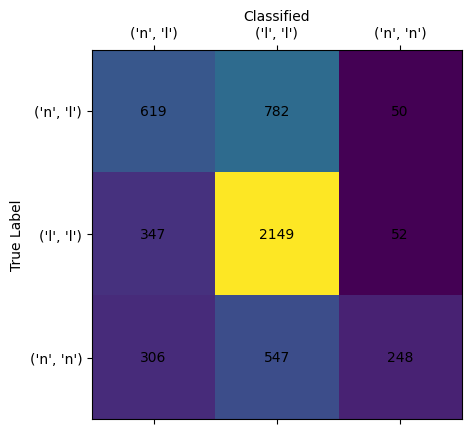

In [35]:
full_mask_dual_comb = torch.tensor(np.arange(0, LX_comb_einf_lab.y.shape[0]))
pred_whole_comb = SAGE1L_TR.model.predictions(LX_comb_einf_lab)
pred_whole_comb_acc = SAGE1L_TR.model.test(LX_comb_einf_lab, full_mask_dual_comb)


print("Whole set Accuracy: " + str(pred_whole_comb_acc))
ev.plot_confusion_matrix(np.array(SAGE1L_TR.nxGraph.y), pred_whole_comb, node_lab_explain.values())


# somehow this bugs
rocL_comb = ev.eval_roc_auc(LX_comb_einf_lab.y, SAGE1L_TR.model.predictions(LX_comb_einf_lab, max_prob = False))
print("ROC AUC: " + str(rocL_comb))


In [10]:

# give more room to the weight decay
sweep_variable_layyer_num = {
    "name": "gcn-sweep",
    "method": "bayes",
    "metric": {
        "name": "gcn/accuracy",
        "goal": "maximize",
    },
    "parameters": {
        
        "models": {
            "values": ["SAGE"]
        },
        "hidden_channels": {
            "values": [64, 128]
        },

        "weight_decay": {
            "distribution": "normal",
            "mu": 2e-4,
            "sigma": 2e-5,
        },
        "lr": {
            "min": 1.5e-4,
            "max": 5e-2
        },
        "dropout": {
            "values": [0.1, 0.5]
        },
        "num_layers": {
            "values": [6, 8]
        }
    }
}

# Register the Sweep with W&B
import wandb
sweep_id = wandb.sweep(sweep_variable_layyer_num, project= "node_classification_comb")

Create sweep with ID: rpo79ibg
Sweep URL: https://wandb.ai/luxtu/node-classification_comb/sweeps/rpo79ibg


In [11]:
# define optimizer and loss
optimizerAdam = torch.optim.Adam
criterionCEL = torch.nn.CrossEntropyLoss

# set seed for reproducibility 
np.random.seed(1234567)

# create the training and testing masks
train_mask = np.random.choice(np.arange(0, LX_comb_einf_lab.y.shape[0]), size= int(LX_comb_einf_lab.y.shape[0]*0.8), replace = False)
test_mask = np.delete(np.arange(0, LX_comb_einf_lab.y.shape[0]), train_mask)

# convert to torch tensor objects
train_mask= torch.tensor(train_mask)
test_mask= torch.tensor(test_mask)


sweeper = nodeClassifier.nodeClassifierSweep(features = np.arange(num_feat_dual_comb), classes = num_class_dual_comb, optimizer = optimizerAdam, lossFunc = criterionCEL, graph = LX_comb_einf_lab,  train_mask = train_mask_dual_comb, test_mask = test_mask_dual_comb, epochs = 500)

#Run the Sweeps agent
#wandb.agent(sweep_id, project="node-classification_comb", function=sweeper.agent_variable_size_model, count=50)


NameError: name 'networkDualXGCombMask' is not defined